In [ ]:
!pip install segmentation_models_pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d2da6a07b680479dd6333b1744d183bc2a8170025ba9c386ac4853af002e426a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=1f064ae2263aff8297ac5f8d21b99068d4a3b60e6ef9484f5de53fef8525857a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import sys
from torch.utils.data import DataLoader, Dataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns



In [ ]:
# Reading the data from the directories

DATA_DIR = "/content/drive/MyDrive/data"
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')



In [ ]:
# Function to visualize some of the data when needed
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        plt.show()



In [ ]:
class CarlaLanesDataset(Dataset):
    CLASSES = ['background', 'left_marker', 'right_marker']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        get_label_name = lambda fn: re.sub(".png", "_label.png", fn)
        self.masks_fps = [os.path.join(masks_dir, get_label_name(image_id)) for image_id in self.ids]

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        if image is None:
            print(f"Error loading image: {self.images_fps[i]}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Placeholder image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], 0)
        if mask is None:
            print(f"Error loading mask: {self.masks_fps[i]}")
            mask = np.zeros((224, 224), dtype=np.uint8)  # Placeholder mask

        mask = mask.astype(np.uint8)
        new_width = (image.shape[1] // 32) * 32  # Calculate new width divisible by 32
        new_height = (image.shape[0] // 32) * 32  # Calculate new height divisible by 32
        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        mask = mask.astype(np.uint8)  # Convert mask to numpy array

        return image, mask

    def __len__(self):
        return len(self.ids)

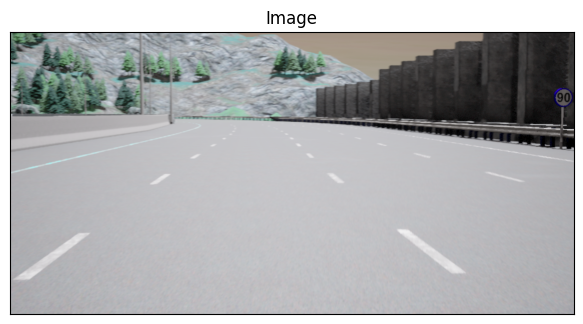

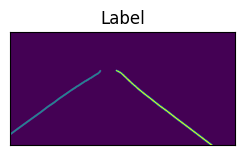

In [ ]:
dataset = CarlaLanesDataset(x_train_dir, y_train_dir, classes=CarlaLanesDataset.CLASSES)
image, mask = dataset[9] # get some image at a particular index

# Visualizing some image from the pytorch dataloader uncomment to apply
visualize(
    image=image,
    label = mask
)


In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=cv2.BORDER_CONSTANT),
        albu.GaussNoise(p=0.2),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)



def get_validation_augmentation():
    return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn, mask=None),  # Apply preprocessing to the image only
        albu.Lambda(image=to_tensor, mask=None),
    ]
    return albu.Compose(_transform)



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


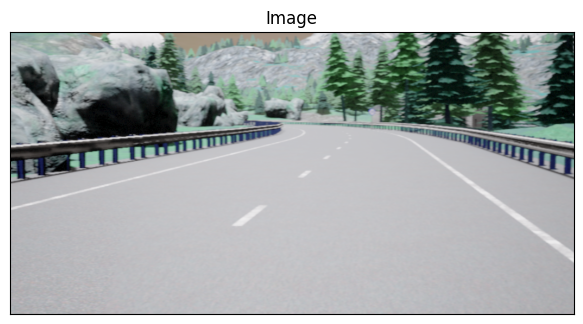

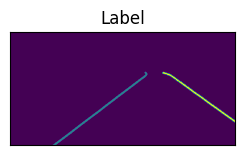

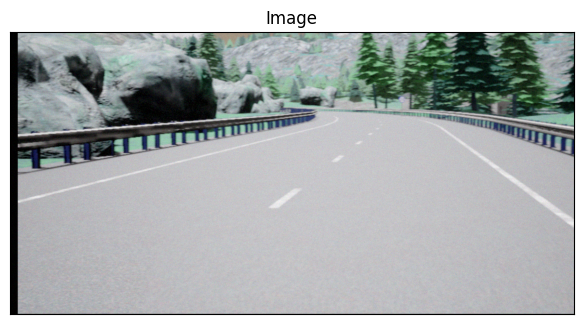

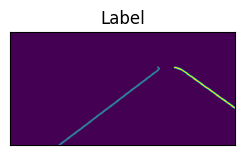

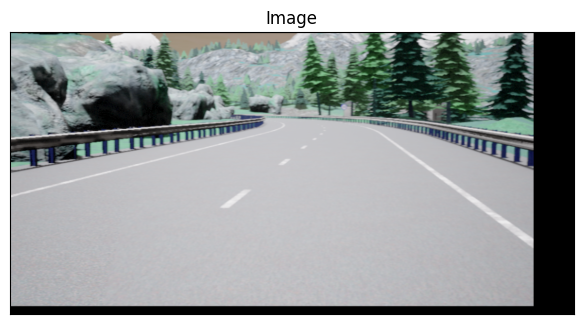

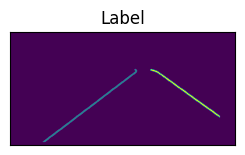

In [ ]:
#  Visualize resulted augmented images and masks
augmented_dataset = CarlaLanesDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CarlaLanesDataset.CLASSES,
)

#showing some of the images after applying the transformations on them
#Uncomment to visualize

for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, label=mask)





In [ ]:
loss_string = 'multi_dice_loss'
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

# Create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CarlaLanesDataset.CLASSES),
    activation=ACTIVATION,

)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
train_dataset = CarlaLanesDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

valid_dataset = CarlaLanesDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

bs_train = 8
bs_valid = 8
train_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs_valid, shuffle=False)
label_left = CarlaLanesDataset.CLASSES.index('left_marker')
label_right = CarlaLanesDataset.CLASSES.index('right_marker')

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()

    def forward(self, y_pr, y_gt):
        sigmoid = torch.nn.Sigmoid()
        y_pr = sigmoid(y_pr)
        left_gt = (y_gt == label_left)
        right_gt = (y_gt == label_right)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:, label_left, :, :], left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:, label_right, :, :], right_gt)
        return (loss_left + loss_right) * 0.5

metrics = []
loss = MultiDiceLoss()
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=1e-4),
])

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 142MB/s] 


## **TRAIN THE** **MODEL**

In [ ]:
# ... (previous code)

# Train model
epochs = 1
best_loss = 1e10
for i in range(epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Print training and validation losses
    print('Training Loss:', train_logs['multi_dice_loss'])  # Adjust the key based on your log dictionary
    print('Validation Loss:', valid_logs['multi_dice_loss'])  # Adjust the key based on your log dictionary


    # Update the best loss and save the model
    if best_loss > valid_logs['multi_dice_loss']:  # Adjust the key based on your log dictionary
        best_loss = valid_logs['multi_dice_loss']  # Adjust the key based on your log dictionary
        torch.save(model, './best_model_{}.pth'.format(loss_string))
        print('Model saved!')

    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train:  25%|██▍       | 96/388 [05:53<17:55,  3.68s/it, multi_dice_loss - 0.9826]


KeyboardInterrupt: ignored

# **# Testing the model**

valid: 100%|██████████| 129/129 [00:39<00:00,  3.31it/s, multi_dice_loss - 0.9799]
{'multi_dice_loss': 0.9798628664756004}
Confusion Matrix:
[[65891091   440151   348978]
 [    6598   495984        0]
 [     822        0   449528]]
Accuracy: 0.988222506619239
Precision: 0.9934849720485999
Recall: 0.988222506619239
F1 Score: 0.9899039828552069


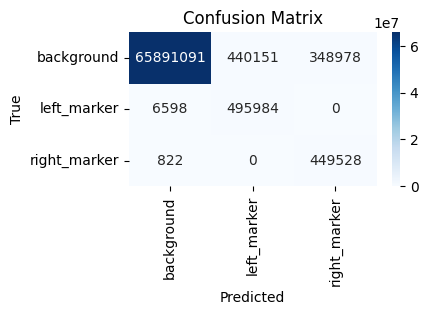

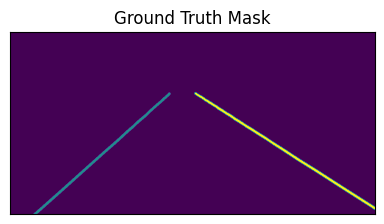

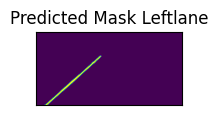

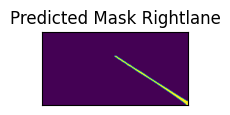

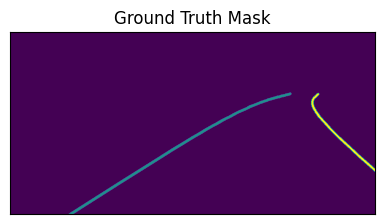

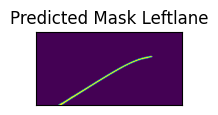

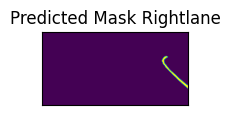

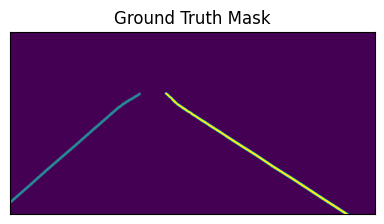

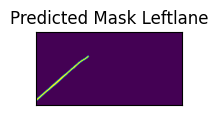

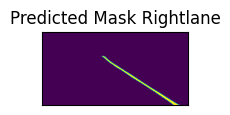

In [ ]:
best_model = torch.load('/content/drive/MyDrive/best_model_multi_dice_loss.pth')

test_best_model = True
if test_best_model:
    # create test dataset
    test_dataset = CarlaLanesDataset(
        x_valid_dir,
        y_valid_dir,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CarlaLanesDataset.CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    # Initialize variables for storing true and predicted labels
    true_labels = []
    predicted_labels = []

    # evaluate model on test set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)
    print(logs)

    # Evaluate model on test set
    for images, masks in test_dataloader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        with torch.no_grad():
            outputs = best_model(images)

        predicted_masks = outputs.argmax(dim=1)
        true_labels.extend(masks.view(-1).cpu().numpy())
        predicted_labels.extend(predicted_masks.view(-1).cpu().numpy())

    # Compute the confusion matrix and accuracy
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')





    print("Confusion Matrix:")
    print(conf_matrix)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CarlaLanesDataset.CLASSES, yticklabels=CarlaLanesDataset.CLASSES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# test dataset without transformations for image visualization
test_dataset_vis = CarlaLanesDataset(
    x_valid_dir, y_valid_dir,
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

for i in range(3):
    n = np.random.choice(len(test_dataset_vis))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0, 1, :, :]
    pr_mask_left = (pr_mask_left.cpu().numpy())

    pr_mask_right = best_model.predict(x_tensor)[0, 2, :, :]
    pr_mask_right = (pr_mask_right.cpu().numpy())

    visualize(
        ground_truth_mask=gt_mask,
        predicted_mask_leftLane=pr_mask_left,
        predicted_mask_rightLane=pr_mask_right
    )




# **Manual** **calculations**

In [1]:
# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate additional performance metrics
#accuracy_manual = (TP + TN) / (TP + TN + FP + FN)
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual)
Pixel_accuracy = (TP +TN)/(TP+TN+FP+FN) # PIXEL ACCURACY
MIou = TP/(TP + FP + FN)                # MEAN INTERACTION OF UNION
er=(FP+FN)/(TP + FP + FN+TP)
dr=TP/(TP+FN)
fp=FN/(TP+FN)
s=TP/(TP+TN) * 100
sp=TN/(FP+TN)*100
fn = 6598 /(6598+495984)
print("TP:", TP)
print("FP:", FP)
print("TN:", TN)
print("FN:", FN)
#print("Accuracy (Manual):", accuracy_manual)
print("Precision (Manual):", precision_manual)
print("Recall (Manual):", recall_manual)
print("F1 Score (Manual):", f1_manual)
print('mIoU:', MIou)
print('PiXel Accuracy:', Pixel_accuracy)
print('detection rate:',dr)
print('sensitivity',s)
print('specificity',sp)
# print('error rate:',er)
# print('false positive rate:', fp)
# print('false negative rate:', fn)


NameError: ignored

In [ ]:

# After training, plot the losses
import matplotlib.pyplot as plt

# epochs = range(1, len(train_losses) + 1)
# plt.plot(epochs, train_losses, 'g', label='Training loss')
# plt.plot(epochs, valid_losses, 'b', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# #This code will accumulate the training and validation losses during each epoch and then plot them after training is complete. Make sure to adjust the key used to access the losses in the log dictionaries ('multi_dice_loss') based on your actual log structure.





